# The social network of the Holy Land (Leviticus 17-26)

In [1]:
#Dataset path
PATH = 'datasets/'

import os, csv, collections, html
from operator import itemgetter
import pandas as pd
os.environ["OMP_NUM_THREADS"] = '1'
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import networkx as nx
from networkx.algorithms import bipartite
import forceatlas2
import random
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

In [2]:
#Importing the Hebrew data and Text-Fabric
from tf.app import use
A = use('etcbc/bhsa', version='c', hoist=globals(), mod='etcbc/heads/tf,ch-jensen/participants/actor/tf')

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.05,100
chapter,929,459.19,100
lex,9233,46.20,100
verse,23213,18.38,100
half_verse,45180,9.44,100
sentence,63727,6.69,100
sentence_atom,64525,6.61,100
clause,88121,4.84,100
clause_atom,90688,4.70,100
phrase,253207,1.68,100


## Occurences of "land" in the Holiness Code (Leviticus 17-26) 

In [3]:
prs_land = []

for w in F.otype.s('word'):
    if F.prs_actor.v(w) and '>RY' in F.prs_actor.v(w):
        prs_land.append(w)
        
print(f'Number of pronominal suffixes referring to or including land: {len(prs_land)}')

Number of pronominal suffixes referring to or including land: 26


### Social network data

In [4]:
data = pd.read_excel(f'{PATH}Lev17-26.edges.xlsx')
data.head()

,Source,Source_agency,Source_ph,Target,Target_agency,Target_ph,Label,Weight,Clause,Ref
0,Aaron's_sons,5,690343.0,YHWH,0,690347.0,swing,25,440323,Leviticus 23:20
1,YHWH,5,690383.0,Moses,-1,690384.0,speak,36,440335,Leviticus 23:23
2,Israelites,5,690397.0,YHWH,-1,690399.0,approach,36,440341,Leviticus 23:25
3,YHWH,5,690402.0,Moses,-1,690403.0,speak,36,440342,Leviticus 23:26
4,Israelites,5,690415.0,YHWH,-1,690417.0,approach,36,440347,Leviticus 23:27


## 1. Network Visualizations

### 1a. One-mode network

In [4]:
G = nx.MultiGraph()

for n, row in data.iterrows():
    if row['Source'] != row['Target']: #Ignoring selfloops, e,g., "YHWH" > "YHWH"
        G.add_edge(row.Source, row.Target)
    
pos = { i : (random.random(), random.random()) for i in G.nodes()}
l = forceatlas2.forceatlas2_networkx_layout(G, pos, niter=2000, gravity=30, scalingRatio=2.0)

In [5]:
landRefs = ['Egypt','golden_table','Canaan','tent_of_meeting','land','heavens','high_place','incense_altar','town'
           'land_of_enemies','altar','entrance_tent_of_meeting','curtain','house','field','standing_stone',
           'village','vineyard','custody','property','mount_Sinai']

weight = collections.Counter(G.edges())

for u, v, d in G.edges(data=True):
    d['weight'] = weight[u, v]

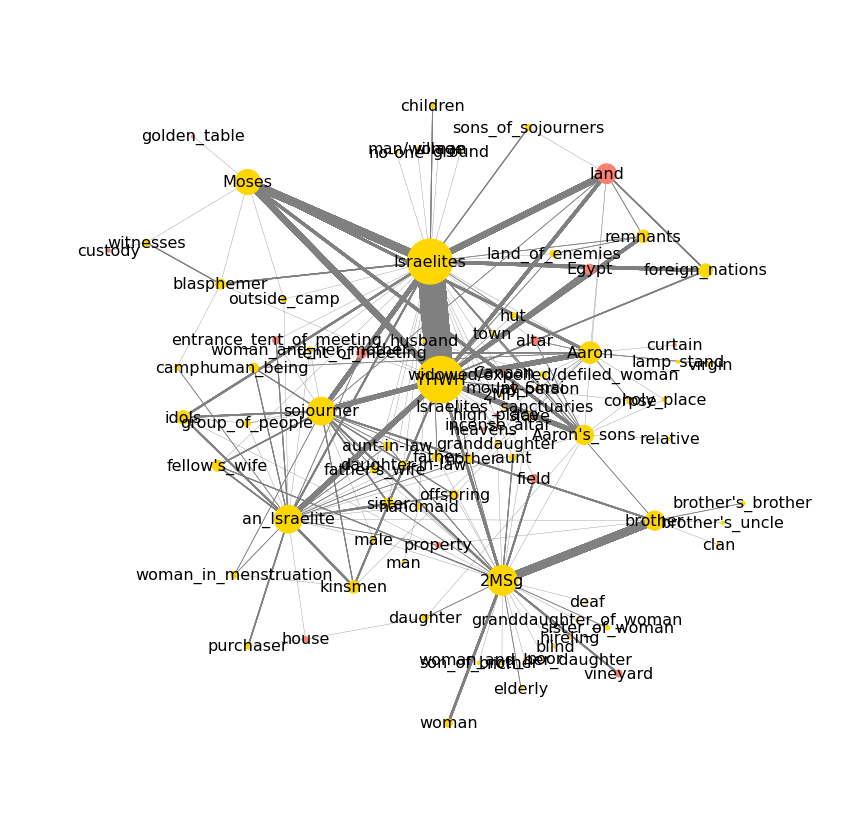

In [6]:
plt.figure(figsize = (15,15))

color_map = []
for node in G:
    if node in landRefs:
        color_map.append('salmon')
    else: 
        color_map.append('gold') 

nx.draw_networkx(G, l, node_color=color_map, node_size=[n[1]*10 for n in G.degree()], 
                 edge_color='grey', width=[d['weight']/3 for _, _, d in G.edges(data=True)], font_size=16)

plt.axis('off')
plt.margins(x=0.1, y=0.1)

plt.savefig('images/full_network.png', dpi=500)
plt.show()

In [7]:
print(f'Nodes: {len(G.nodes())}\nEdges: {len(G.edges())}')

Nodes: 87
Edges: 605


In [11]:
print(f'Space nodes: {len([n for n in G.nodes if n in landRefs])}')
print(f'People nodes: {len(G.nodes)-len([n for n in G.nodes if n in landRefs])}')

Space nodes: 18
People nodes: 69


### 1b. Two-mode network

Transform network into bipartite:

In [ ]:
B = nx.Graph()

landRefs = ['Egypt','golden_table','Canaan','tent_of_meeting','land','heavens','high_place','incense_altar','town',
           'land_of_enemies','altar','entrance_tent_of_meeting','curtain','house','field','standing_stone',
           'village','vineyard','custody','property','mount_Sinai','lamp_stand','hut','outside_camp','camp',
           'holy_place',"Israelites'_sanctuaries",'ground']

In [ ]:
edges = []

for n, row in data.iterrows():
    if row['Source'] == row['Target']: #Ignoring selfloops, e,g., "YHWH" > "YHWH"
        continue
    elif row['Source'] in landRefs and row['Target'] in landRefs:
        continue
    elif row['Source'] not in landRefs and row['Target'] not in landRefs:
        continue
    elif row['Source'] in landRefs:
        edges.append((row['Target'],row['Source']))
    else:
        edges.append((row['Source'], row['Target']))

df = pd.DataFrame(edges, columns=['people','space'])

B = nx.Graph()

B.add_nodes_from(df['people'], bipartite=0)
B.add_nodes_from(df['space'], bipartite=1)
B.add_weighted_edges_from(
    [(row['people'], row['space'], 1) for idx, row in df.iterrows()], 
    weight='weight')

In [ ]:
S = [B.subgraph(c).copy() for c in nx.connected_components(B)]
for s in S:
    print(s)

In [ ]:
#Remove nodes not included in the largest network:
for s in S[1:]:
    for n in s.nodes:
        B.remove_node(n)
        print(f'{n} ... deleted')

In [ ]:
plt.figure(figsize = (15,15))

pos = nx.spring_layout(B)


top_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
bottom_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 1]

nx.draw_networkx_nodes(B, pos=pos, nodelist=top_nodes, node_size=[n[1]*100 for n in B.degree() if n[0] in top_nodes],
                      node_shape='o', node_color='gold')
nx.draw_networkx_nodes(B, pos=pos, nodelist=bottom_nodes, node_size=[n[1]*100 for n in B.degree() if n[0] in bottom_nodes],
                      node_shape='^', node_color='salmon')
nx.draw_networkx_edges(B, pos, alpha=0.5)

for p in pos:  # raise text positions
    pos[p][1] -= 0.03
nx.draw_networkx_labels(B, pos, labels=None)

plt.axis('off')
plt.margins(x=0.1, y=0.1)

plt.savefig('images/two_mode_network.png', dpi=500)

plt.show()

## 2. Network measures

### 2a. Cohesion and network density

One of the simplest measures of cohession ("knittedness") is probably density. Density is simply the number of ties in the network proportional to the possible number of ties.

In [ ]:
G1 = nx.Graph()

for n, row in data.iterrows():  
    G1.add_edge(row.Source, row.Target)

In [ ]:
print(f'Number of edges: {len(G1.edges)}')

In [ ]:
nx.density(G)

Density is sensitive to the size of the network, and large networks tend to have lower density than small networks, simply because it is more realistic for a member of a small network to be connected with most of the remaining participants than in a large network.

Therefore, another approach is average degree:

In [ ]:
degree = G.degree()
sum_degree = sum(dict(degree).values())
print(f'Average degree: {sum_degree/len(G.nodes())}')

In [ ]:
G = nx.MultiDiGraph()

for n, row in data.iterrows():  
    G.add_edge(row.Source, row.Target)

In [ ]:
outdegree_sequence = collections.Counter(sorted([d for n, d in G.out_degree()], reverse=True))
indegree_sequence = collections.Counter(sorted([d for n, d in G.in_degree()], reverse=True))

outdegree_df = pd.DataFrame(outdegree_sequence, index=[0]).T
indegree_df = pd.DataFrame([indegree_sequence]).T

In [ ]:
degree_df = pd.concat([indegree_df, outdegree_df], axis=1, sort=False)
degree_df.columns = ['indegree','outdegree']
degree_df

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

plt.bar(degree_df.index, degree_df.indegree, width=0.33)
plt.bar(degree_df.index+0.33, degree_df.outdegree, color='tomato', width=0.33)

ax.legend(labels=['indegree', 'outdegree'], fontsize=14)
plt.ylabel("Count", size=14)
plt.xlabel("Degree", size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

Cumulative:

In [ ]:
indegree_cum = [n/len(G.nodes())*100 for n in np.cumsum(degree_df.fillna(0).indegree)]
outdegree_cum = [n/len(G.nodes())*100 for n in np.cumsum(degree_df.fillna(0).outdegree)]
degree_df.insert(2, "indegree_cum (%)", indegree_cum)
degree_df.insert(3, "outdegree_cum (%)", outdegree_cum)

In [ ]:
degree_df

Most connected participants:

In [ ]:
top_degree = sorted(dict(degree).items(), key=itemgetter(1), reverse=True)

A cummulative view:


In [ ]:
cum_degree = pd.DataFrame(top_degree)
cum_degree.columns = ['participant','degree']

degree_cum = [n/(len((G.edges()))*2)*100 for n in np.cumsum(cum_degree.degree)]
cum_degree.insert(2, "degree_cum (%)", degree_cum)

In [ ]:
cum_degree.head(10)

Updated graph:


In [ ]:
fig, ax1 = plt.subplots(figsize=(15,7))
ax2 = ax1.twinx()
ax1.tick_params(axis='both', which='major', labelsize=16)

ax1.bar(degree_df.index, degree_df.indegree, width=0.33)
ax1.bar(degree_df.index+0.33, degree_df.outdegree, color='tomato', width=0.33)

ax2.plot(degree_df.index, degree_df['indegree_cum (%)'], linestyle='--', alpha=0.5, linewidth=2)
ax2.plot(degree_df.index, degree_df['outdegree_cum (%)'], linestyle='--', alpha=0.5, linewidth=2)

ax1.legend(frameon=1, labels=['indegree', 'outdegree'], fontsize=16, facecolor='white', framealpha=1, loc='right')
ax1.set_ylabel("Count", size=20)
ax2.set_ylabel("Cumulative %", size=20)
ax1.set_xlabel("")
plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig(f'images/accumulative_degree.png', bbox_inches='tight', dpi=500)
plt.show()

Inspect values:

In [ ]:
G.degree()

In [ ]:
G.in_degree()

## 2b. Reciprocity

Reciprocity concerns whether an interaction from one actor to another is returned, or whether the relation is one-sided. A simple measure of reciprocity is to count the number of reciprocal ties and divide these by the total number of ties. For this analysis, we are not interested in the weights of the edges but simply the binary value (connected or not).

In [ ]:
digraph = nx.DiGraph()

for n, row in data.iterrows():
    digraph.add_edge(row.Source, row.Target)

In [ ]:
round(nx.reciprocity(digraph)*100, 2)

In [ ]:
reci_df = pd.DataFrame([nx.reciprocity(digraph, digraph.nodes())]).T.sort_values(by=0, ascending=False).head(30)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

plt.bar(reci_df.index, reci_df[0])
plt.ylabel("fraction", size=20)
plt.xticks(size=16, rotation=45, ha='right')
plt.yticks(size=16)
plt.savefig(f'images/reciprocity.png', bbox_inches='tight', dpi=500)
plt.show()

### 2c. Centrality

We use 4 measures for measuring the centrality of individual nodes. That will give an image of core and periphery of the network. The four measures are Degree, Closeness, Betweenness, and PageRank.

In [ ]:
indegree = nx.in_degree_centrality(digraph)
outdegree = nx.out_degree_centrality(digraph)
betweenness = nx.betweenness_centrality(digraph)
pagerank = nx.pagerank(digraph)

In [ ]:
centrality = pd.DataFrame([indegree, outdegree, betweenness, pagerank]).T
centrality.columns = ['indegree','outdegree','betweeness','pagerank']
centrality

Top-10 scores for centrality measures:

In [ ]:
def top(measure, df=centrality):
    return df.sort_values(by=measure, ascending=False)[measure][:10]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,7), sharey=True)
fig.tight_layout(pad=1.0)

ax1.bar(top('outdegree').index, top('outdegree'))
ax1.set_title("Outdegree", size=22)
ax2.bar(top('indegree').index, top('indegree'))
ax2.set_title("Indegree", size=22)
ax3.bar(top('betweeness').index, top('betweeness'))
ax3.set_title("Betweenness", size=22)
ax4.bar(top('pagerank').index, top('pagerank'))
ax4.set_title("PageRank", size=22)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right', size=18)
    plt.yticks(size=18)

plt.savefig(f'images/centrality_scores.png', bbox_inches='tight', dpi=500)
plt.show()

#### Biparpitite graph

In [ ]:
degree = nx.degree_centrality(B)
betweenness = nx.betweenness_centrality(B)
pagerank = nx.pagerank(B)

In [ ]:
centrality = pd.DataFrame([degree, betweenness, pagerank]).T
centrality.columns = ['degree','betweeness','pagerank']
centrality

In [ ]:
def top(measure, df=centrality):
    return df.sort_values(by=measure, ascending=False)[measure][:10]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7), sharey=True)
fig.tight_layout(pad=1.0)

ax1.bar(top('degree').index, top('degree'))
ax1.set_title("Degree", size=22)
ax2.bar(top('betweeness').index, top('betweeness'))
ax2.set_title("Betweenness", size=22)
ax3.bar(top('pagerank').index, top('pagerank'))
ax3.set_title("PageRank", size=22)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right', size=18)
    plt.yticks(size=18)

plt.savefig(f'images/two_mode_centrality_scores.png', bbox_inches='tight', dpi=500)
plt.show()

## 3. Node equivalence with Node2Vec

In [9]:
def getEmbeddings(file, nodes):
    with open(file) as f:
        mylist = [line.rstrip('\n') for line in f]

    embeddings_dict = collections.defaultdict()
    for l in mylist[1:]:
        vector = l.split()
        embeddings_dict[vector[0]] = [float(i) for i in vector[1:]]

    """Extract representations from the node2vec model"""
    embeddings = [embeddings_dict[n] for n in nodes]
    embeddings = np.array(embeddings)
    return embeddings

def elbow(X,max_clusters=10):

    wcss = [] #for storing the intertia property

    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters), wcss)
    plt.title('Scree plot of WCSS for n clusters (elbow method)')
    plt.xlabel('n of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
def draw(graph, X, kmeans, labels=True, size=(15,15), save=str()):

    plt.figure(figsize = size)
    
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph),
        with_labels=labels,
        node_size=[n[1]*8 for n in G.degree()],
        node_color=kmeans.labels_,
        edge_color='grey'
        )
    
    plt.axis('off')
    if save:
        plt.savefig(fname=f'images/{save}.png', bbox_inches='tight', dpi=500)
    plt.show()
    
def mds(graph, X, kmeans, n_components=2, label=True, labelList = list(), size=(7,7), save=str()):
    embedding = MDS(n_components=2)
    X_transformed = embedding.fit_transform(X)
    X = pd.DataFrame(X_transformed, index=graph.nodes)
    
    plt.figure(figsize=size)
    plt.scatter(X.iloc[:,0],X.iloc[:,1], c=kmeans.labels_)
    
    if labelList:
        for n, row in X.iterrows():
            if n in labelList:
                plt.text(row[0],row[1],n, size=18)        

    elif label:
        for n, row in X.iterrows():
            plt.text(row[0],row[1],n, size=18)

    plt.xticks(size=18)
    plt.yticks(size=18)
    if save:
        plt.savefig(fname=f'images/{save}.png', bbox_inches='tight', dpi=500)
    
    plt.show()

### 3a. Simple, directed graph

In [ ]:
G = nx.DiGraph()

for n, row in data.iterrows():
    G.add_edge(row.Source, row.Target)

In [ ]:
node2vec = Node2Vec(B, dimensions=dim, walk_length=wl, num_walks=nw, p=p, q=q)

In [ ]:
dim = 16
wl = 3
nw = 100
p=1
q=2

Definitions:
* window (size) = the maximum distance between the current and the predicted node in the vector
* min_count = ignores all words with total absolute frequency lower than this

In [ ]:
model = node2vec.fit(window=6, min_count=1)

In [ ]:
model.wv.save_word2vec_format('node2vec/simple_directed_bipartite')

#### How many clusters?

The more clusters, the less the distance is between the centroid and its members. This is measured with WCSS ("within-cluster sum of squares").

In [ ]:
simple = getEmbeddings('node2vec/simple_directed', B.nodes())

elbow(simple)

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(simple)

In [ ]:
mds(B, simple, kmeans, size=(15,15), save='node2vec_simple_directed_bipartite')

### 3b. Directed and valued graph

Create dataset with edges including mean agency scores for weight. Each edge must occur only once.

In [78]:
edges = set()

for n, row in data.iterrows():
    if row['Source'] == row['Target']: #Ignoring selfloops, e,g., "YHWH" > "YHWH"
        continue
    else:
        edges.add((row['Source'], row['Target']))

df = pd.DataFrame(edges, columns=['Source','Target'])

mean_agency = []
for n, row in df.iterrows():
    agency_scores = list(data[(data.Source == row.Source) & (data.Target == row.Target)].Weight)
    agency_sum = sum(agency_scores)
    mean_agency.append(agency_sum/len(agency_scores))
    
df['MeanAgency'] = mean_agency

df = df[df.MeanAgency != 0]

In [79]:
fh = open("graph_agency.edgelist", "w")

for n, row in df.iterrows():
    fh.write(f'{row.Source} {row.Target} {row.MeanAgency}\n')

fh.close()

Read dataset

In [81]:
G = nx.read_edgelist("graph_agency.edgelist", create_using=nx.DiGraph, data=(('weight', float),))

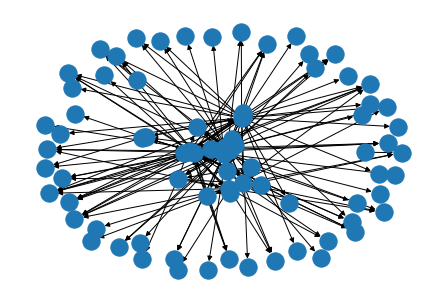

In [34]:
nx.draw(G)

In [35]:
from pecanpy import pecanpy as node2vec

In [36]:
g = node2vec.PreComp(p=5, q=0.5, workers=3, verbose=True, extend=True)
g.read_edg("graph_agency.edgelist", weighted=False, directed=False, delimiter=' ')
g.preprocess_transition_probs()

In [61]:
embeddings = g.embed(dim=128, num_walks=100, walk_length=3, window_size=5, epochs=1)

  0%|                                                                                         | 0/8500 [00:00<…

C:\Users\Christian\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Christian\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Christian\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Christian\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memor

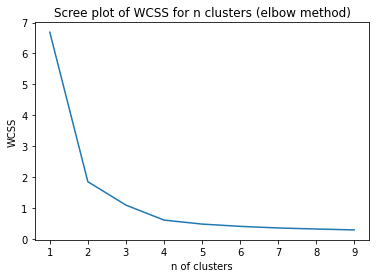

In [62]:
elbow(embeddings)

In [63]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(embeddings)

C:\Users\Christian\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


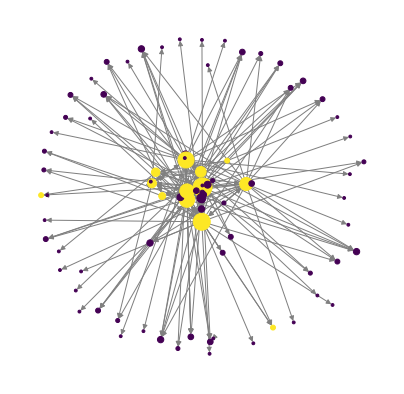

In [64]:
draw(G, embeddings, kmeans, labels=False, size=(7,7), save='node2vec_embeddings_graph')

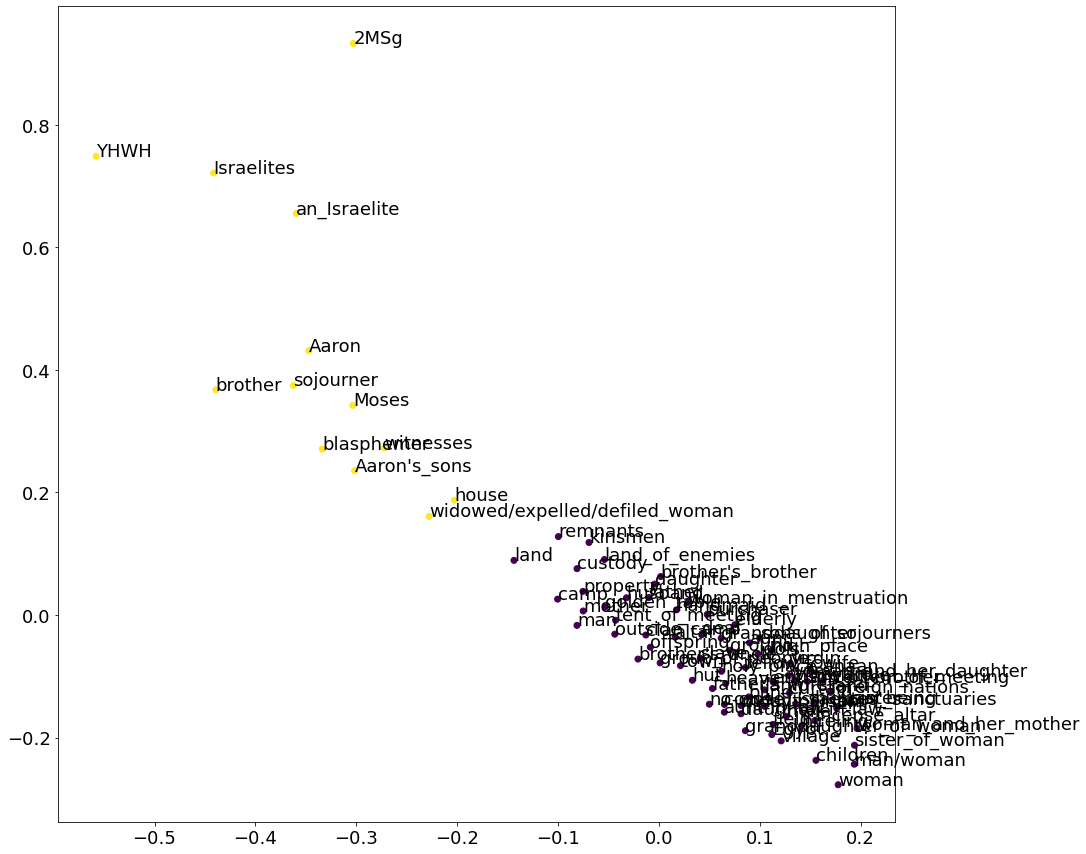

In [65]:
mds(G, embeddings, kmeans, size=(15,15), save='node2vec_valued')

In [80]:
G.nodes()

NodeView(())

## 4. Ego-network and roles

### 4a. Ego-networks

In [5]:
G = nx.MultiDiGraph()
for n, row in data.iterrows():
    if row['Source'] != row['Target']: #Ignoring selfloops, e,g., "YHWH" > "YHWH"
        G.add_edge(row.Source, row.Target, value=row.Label)

In [7]:
def draw_ego(graph, actor, size=(10,10), data=data, save=False, bw=False):    
    plt.figure(figsize = size)

    ego = nx.ego_graph(graph, actor, undirected=True, radius=1)
    
    #Print edge labels
    edge_labels = collections.defaultdict(set)
    
    for e in ego.edges(data='value'):
        edge_labels[(e[0],e[1])].add(e[2])
        
    for e in edge_labels:
        print('''{0:30}{1:30}'''.format(' -> '.join(e), ', '.join(edge_labels[e])))

    pos=nx.spring_layout(ego)
    nx.draw(
        ego,
        pos=pos,
        with_labels=True,
        edge_color='grey',
        node_color='lightgrey' if bw else 'lightblue',
        node_size=[n[1]*10 for n in ego.degree()],
        font_size=20
        )
    nx.draw_networkx_nodes(ego, pos=pos, nodelist=[actor], node_color='lightgrey' if bw else 'salmon', node_size=ego.degree(actor)*10)
    plt.margins(x=0.1, y=0.1)
    if save:
        plt.savefig(fname=f'images/{save}.png', dpi=500)
    plt.show()

Aaron -> YHWH                 give, approach, slaughter, arrange, defile
Aaron -> Israelites           lift                          
Aaron -> land                 prune                         
sojourner -> YHWH             be slight, make, approach, bore, defile
foreign_nations -> YHWH       loath                         
foreign_nations -> Israelites hurt, perish, give, tread, to rule
Israelites -> sojourner       burn, stone, die, dwell, hide, oppress
Israelites -> foreign_nations buy, pursue, fall             
Israelites -> YHWH            come, be holy, be high, walk, swear, give, hear, rejoice, admonish, approach, slaughter, defile, abhor
Israelites -> remnants        remain                        
Israelites -> Aaron's_sons    come                          
Israelites -> land            come, do, call, give, pass, trample down, be unclean
Israelites -> sons_of_sojournerstake possession, buy, work, serve
YHWH -> Aaron                 go out, be holy, cut          
YHWH -> sojour

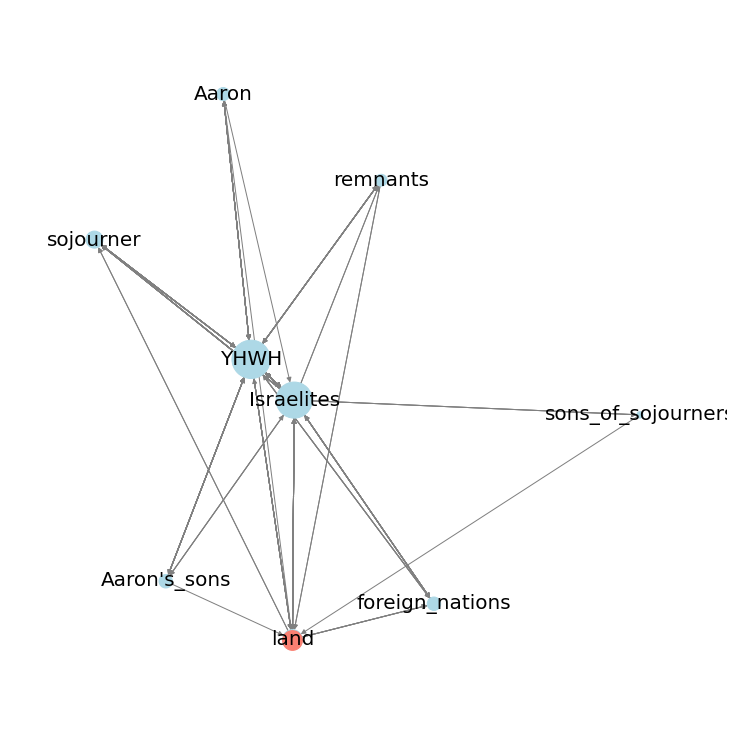

In [9]:
draw_ego(G, "land", save='land_egonetwork')

### 4b. Interactions between two participants

In [86]:
def show(Actor, Undergoer, verb=list(), data=data):
    
    clauses = []
    
    if verb:
        clauses = data[(data.Source == Actor) & (data.Target == Undergoer) & (data.Label.isin(verb))].Clause
    else:
        clauses = data[(data.Source == Actor) & (data.Target == Undergoer)].Clause
    
    if clauses.any():
        
        #Write clause references
        clause_list = list(set(clauses))
        clause_list.sort()
        
        ref_string = '''{} {}:{}'''.format(*T.sectionFromNode(clause_list[0]))
        for cl in clause_list[1:]:
            bo, ch, ve = T.sectionFromNode(cl)
            
            prec_cl = clause_list.index(cl)-1
            prec_bo, prec_ch, prec_ve = T.sectionFromNode(clause_list[prec_cl])
            if ch == prec_ch and ve == prec_ve:
                if '×' in ref_string[-3]:
                    indices = (ref_string.rindex('×'), ref_string.rindex(')'))
                    existing_value = ref_string[indices[0]+1:indices[1]]
                    new_value = str(int(existing_value)+1)
                    ref_string = ref_string[:indices[0]+1] + new_value + ref_string[indices[0]+len(new_value)+1:]
                else:
                    ref_string += f' (×2)'
            elif ch == prec_ch:
                ref_string += f', {ve}'
            else:
                ref_string += f'; {ch}:{ve}'
                    
        print(f'{ref_string}.')
        
        #Display clauses
        for cl in clause_list:
            A.pretty(cl)
            
    else:
        return "No relevant clauses to return"

In [117]:
show("blasphemer","camp")

Leviticus 24:10.


In [112]:
show("YHWH","land_of_enemies")

Leviticus 26:36, 41.


### 4c. Roles

In [36]:
def Roles(actor, data=data, width=int(), bw=False, save=False):
    
    agency = []
    df = data[(data.Source == actor) | (data.Target == actor)]
    
    for n, row in df.iterrows():
        if row.Source == actor:
            agency.append((row.Target,row.Source_agency))
        else:
            agency.append((row.Source,row.Target_agency))

    new_df = pd.DataFrame(agency)
    new_df.columns = ['participant', 'agency']

    mean = new_df.groupby('participant')['agency'].mean().sort_values()
    mean_df = pd.DataFrame(mean)
    print(f'Mean agency of {actor}: {round(new_df.agency.mean(), 3)}')
    
    custom_palette = {}
    for n, row in mean_df.iterrows():
        if row.agency < -1:
            custom_palette[n] = "#d9dddc" if bw else "#E50600" 
        elif row.agency >= -1 and row.agency < 0:
            custom_palette[n] = "#d0d4d4" if bw else "#ED5955"
        elif row.agency >= 0 and row.agency < 1:
            custom_palette[n] = "#c7cbcb" if bw else "#D2E3F0" 
        elif row.agency >= 1 and row.agency < 2:
            custom_palette[n] = "#bdc3c2" if bw else "#A5C8E1"
        elif row.agency >= 2 and row.agency < 3:
            custom_palette[n] = "#b4bab9" if bw else "#78ADD2"
        elif row.agency >= 3 and row.agency < 4:
            custom_palette[n] = "#aab2b1" if bw else "#4B92C3"
        elif row.agency >= 4:
            custom_palette[n] = "#a1a9a8" if bw else "#1f77b4"
            
    g= sns.catplot(x='participant', y='agency', kind='bar', order=mean.index, data=new_df, palette=custom_palette)
    #g.fig.set_size_inches(len(mean_df)*width,5)
    plt.ylabel('mean agency', size=20)
    plt.xlabel('')
    plt.yticks(size=16)
    plt.xticks(size=16, rotation=45, ha='right')
    
    if save:
        plt.savefig(fname=f'images/{save}.png', dpi=500, bbox_inches='tight')

    plt.show()

Mean agency of land: -0.077


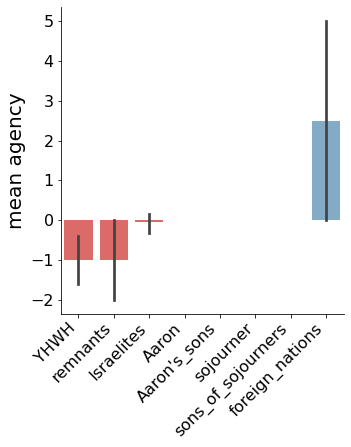

In [37]:
Roles('land', width=0.8, bw=False)